## Unsupervised Clustering 

California Housing Dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

## Objetivo

Generar modelos de clustering no supervisado y explicar insights de estos clusters, utilizar métricas para evaluar modelos.

## California Housing Dataset

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import os
import math
from matplotlib.ticker import PercentFormatter


from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
from myWorkers import closest_coastline
from itertools import product

In [2]:
x = fetch_california_housing()
print(x['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## Dataset Source y analisis preliminar

- Se obtiene el dataset de la API de sklearn y se guarda en una carpeta
- Se une la variable target para incorporarla al análisis y se muestra la estructura resultante
- Se corrobora que no hay nulos
- Se muestra un resumen estadístico de las variables
- Se hacen histogramas de las variables para visualizar sus distribuciones
- Se hacen histogramas en escala logaritmica para visualizar la cantidad de valores en ciertos bins de los histogramas anteriores
    - Se observa que para MedHouseVal hay una frecuencia inusualmente elevada para 5 (cientos de miles de dolares). Se supondrá que se agruparon todas las propiedades con valores mayores o iguales a este valor.
    - Se observa que para HouseAge hay un frecuencia inusualmente elevada para 50 años. Se supondrá que se agruparon todas las propiedades con antiguedades mayores o iguales a este valor.

In [3]:
try:
    os.mkdir('./datasets')
except:
    pass

X,y = fetch_california_housing(data_home='./datasets', 
                                      download_if_missing=True, 
                                      return_X_y=True, 
                                      as_frame=True)

In [4]:
df = pd.concat((X,y),axis=1)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
df.isna().mean()

MedInc         0.0
HouseAge       0.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
MedHouseVal    0.0
dtype: float64

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

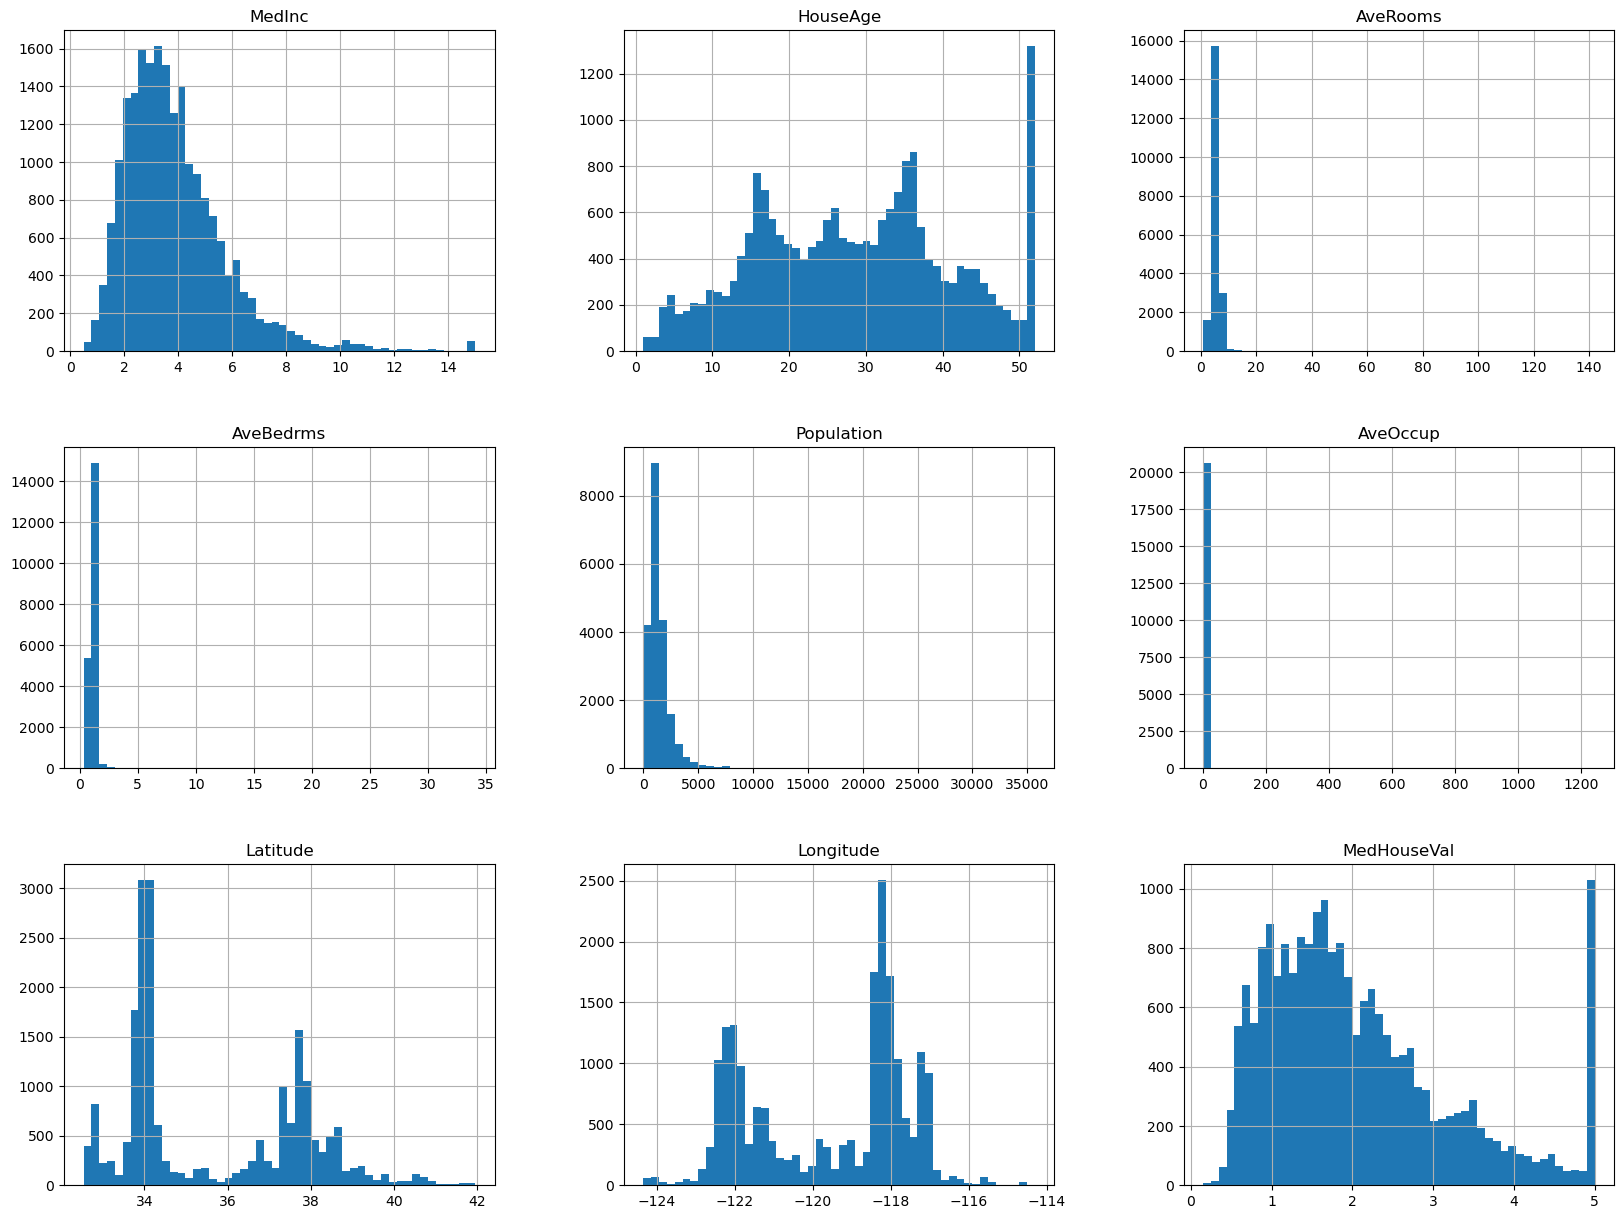

In [7]:
df.hist(bins=50,figsize=(20,15))

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

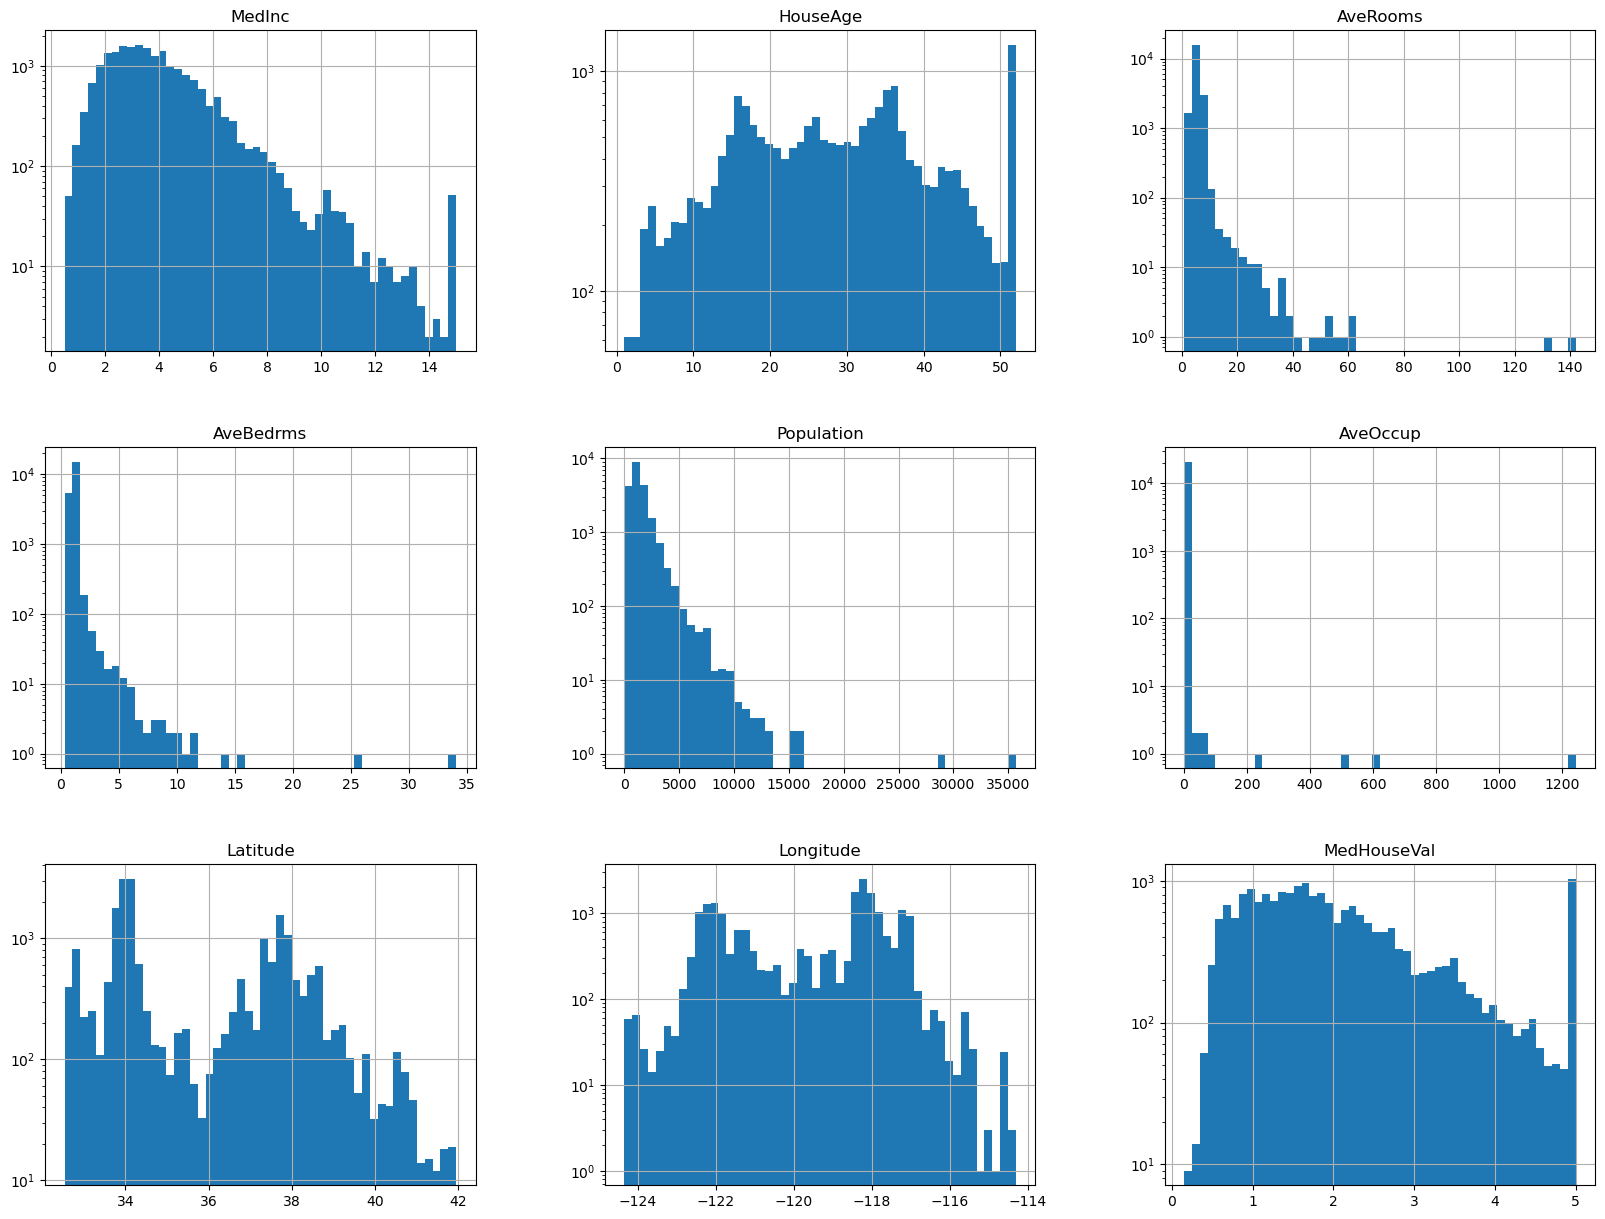

In [8]:
df.hist(bins=50,figsize=(20,15),log=True)

## Plot geográfico y generación de variable Distancia a la costa

- Al contar con la latitud y longitud de cada propiedad se puede mostrar en un mapa.
- Se utiliza geopandas y se descargan:
    - Fronteras de cada condado (county) para california: https://data.ca.gov/dataset/ca-geographic-boundaries
    - Linea de costa de california: https://geodata.lib.utexas.edu/catalog/stanford-hj484bt5758
- Se añade el fondo del mapa con contextly
- Todo debe ser proyectado en la proyección EPSG:4326: https://epsg.io/4326
- Para calcular la distancia a la costa se calcula la distancia de cada propiedad a cada punto de la costa y se obtiene el mínimo. Este cálculo es se hace en una línea recta. Este cálculo tarda aproximadamente 400 ms para cada punto, y por lo 20k puntos del dataframe tardaría aproximadamente 2.5 horas. Se utiliza multiprocessing para mejorar este tiempo y se guarda el dataframe con la distancia más próxima a la costa en un archivo CSV. Se usará este CSV como fuente

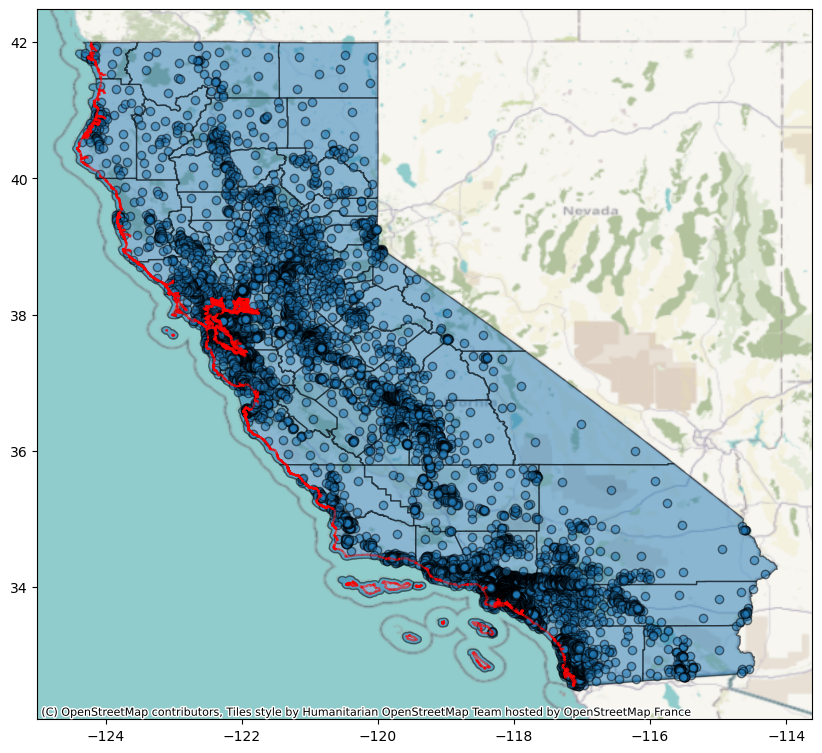

In [9]:
df_gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude),crs="EPSG:4326")
cal_counties = gpd.read_file('./datasets/CA_counties/CA_Counties_TIGER2016.shp')
cal_coastline = gpd.read_file('./datasets/CA_coastline/coastn83.shp')

fig,ax=plt.subplots(figsize=(10,10))
cal_counties.to_crs("EPSG:4326").plot(ax=ax,alpha=0.5,edgecolor='k')
cal_coastline.to_crs("EPSG:4326").plot(ax=ax,alpha=0.5,edgecolor='r')
df_gdf.to_crs("EPSG:4326").plot(ax=ax,alpha=0.5,edgecolor='k')
ctx.add_basemap(ax=ax,crs="EPSG:4326")

In [10]:
input_coast_df = gpd.read_file('./datasets/CA_coastline/coastn83.shp').to_crs(3006)
points = df_gdf.to_crs(3006)['geometry'][0:20]

In [11]:
%%time
# Test 20 puntos sin multiprocessing
print([val for val in map(closest_coastline,repeat(input_coast_df),points)])

[7.66, 7.44, 5.54, 4.79, 4.79, 4.79, 4.05, 4.05, 3.75, 4.05, 3.74, 3.74, 3.74, 3.75, 3.74, 3.74, 2.7, 2.7, 3.75, 2.75]
CPU times: total: 8.44 s
Wall time: 8.44 s


In [12]:
%%time
# Test 20 puntos con multiprocessing
if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=8) as ppe:
        results = ppe.map(closest_coastline, repeat(input_coast_df),points)
    print(list(results))

[7.66, 7.44, 5.54, 4.79, 4.79, 4.79, 4.05, 4.05, 3.75, 4.05, 3.74, 3.74, 3.74, 3.75, 3.74, 3.74, 2.7, 2.7, 3.75, 2.75]
CPU times: total: 3.36 s
Wall time: 4.05 s


In [13]:
# Calculo de distancia a costa de todos los puntos, 
# no ejecutar nuevamente, se guarda el procesamiento en un csv
"""
%%time
points = df_gdf.to_crs(3006)['geometry']
if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=8) as ppe:
        results = ppe.map(closest_coastline, repeat(input_coast_df),points)
    df['CoastDist'] = list(results)
    
df.to_csv('./datasets/CaliforniaHousing_CostalDist.csv',index=False)
""" 
#CPU times: total: 52min 17s
#Wall time: 53min 54s

"\n%%time\npoints = df_gdf.to_crs(3006)['geometry']\nif __name__ == '__main__':\n    with ProcessPoolExecutor(max_workers=8) as ppe:\n        results = ppe.map(closest_coastline, repeat(input_coast_df),points)\n    df['CoastDist'] = list(results)\n    \ndf.to_csv('./datasets/CaliforniaHousing_CostalDist.csv',index=False)\n"

In [14]:
df = pd.read_csv('./datasets/CaliforniaHousing_CostalDist.csv')
df.head()

n_points_raw = len(df)

## Visualización de datos geográficamente

- Se muestra en un plot geográfico en una escala de color:
    - La mediana de valor de las propiedades del condado
    - La mediana del salario del condado 
    - La distancia a la costa (para corroborar el cálculo anterior)

<Axes: xlabel='Longitude', ylabel='Latitude'>

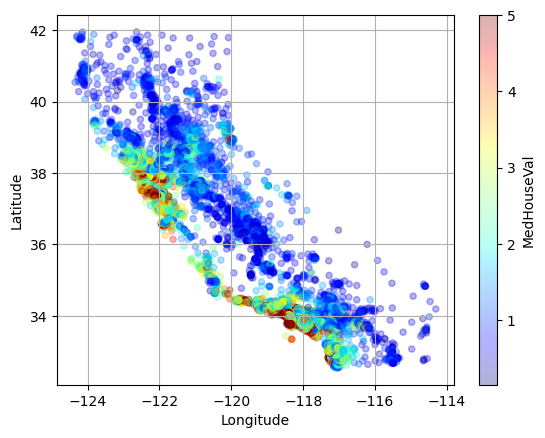

In [15]:
df.plot(kind='scatter',
        x='Longitude',y='Latitude',
        alpha=0.3,
        c='MedHouseVal',
        cmap='jet',
        grid=True)

<Axes: xlabel='Longitude', ylabel='Latitude'>

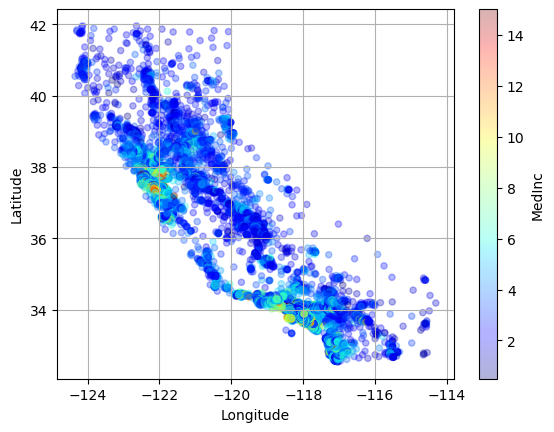

In [16]:
df.plot(kind='scatter',
        x='Longitude',y='Latitude',
        alpha=0.3,
        c='MedInc',
        cmap='jet',
        grid=True)

<Axes: xlabel='Longitude', ylabel='Latitude'>

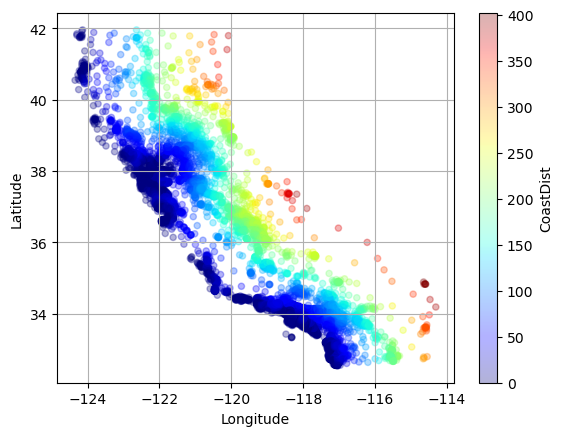

In [17]:
df.plot(kind='scatter',
        x='Longitude',y='Latitude',
        alpha=0.3,
        #s=df['MedHouseVal']*10,
        c='CoastDist',
        cmap='jet',
        grid=True)

In [18]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'CoastDist'],
      dtype='object')

## Outliers

Para quitar outliers se utilizó el criterio del rango medio intercuartil (IQR), donde se calcula que los outliers son aquellas observaciones menores a $1.5*Q_1$ y mayores a $1.5*Q_3$, donde $Q_1$ es el valor de la variable por debajo del que se encuentran el 25\% de las observaciones y $Q_3$ es el valor de la variable por debajo del que se encuentras el 75\% de las observaciones (también son llamados $Q_{25\%}$ y $Q_{75\%}$). 

Se realizaron los histogramas y boxplots de las variables cuantitativas del dataset y se obtiveron las siguientes conclusiones.

- Para la variable _MedInc_, _MedHouseVal_, _HouseAge_ y se quitan los outliers con el criterio de rango intercuartil, ya que sus distribuciones se asemejan a una distribución normal. En cada caso 
- Para la variable _AveRooms_ y _AveBedms_ se utiliza el criterio del rango intercuartil, ya que se estima que al ser un promedio del condado, debería tender a una distribución normal por el teorema del límite central
- Para la variable _HouseAge_ se quitan todos los valores mayores a 50, porque se estima que se han agrupado todas las propiedades de más de 50 años por el valor que se muestra en los histogramas de resumen
- Para las variable _Population_ y _AveOccup se quitan algunos registros inusualmente altos. Si bien existen más outliers con el criterio del IQR, su comportamiento no es el de una variable con una distribición normal o gausseana, por lo que utilizar este criterio para quitar los outliers sería erroneo: se realizará el análisis sin quitarlos.
- Las variables _Latitude_ y _Longitude_ no presentan outliers, además se corroboró que geográficamente exista un punto fuera de California
- Para la variable CoastDist, al ser una variable calculada a partir de un método propuesto, no se considera que deba utilizarse para remover datos del dataset

## Conclusiones de quitar outliers

- Luego de quitar outliers se comprueba que se conservan el 80% de los datos para continuar el análisis
- Se realiza un nuevo conjunto de histogramas para visualizar el dataset filtrado
- Como nota adicional, se menciona que se debería hacer pruebas de bondad de ajuste como ChiSquared o Kolmogórov-Smirnov que escapan al alcance de este análisis.


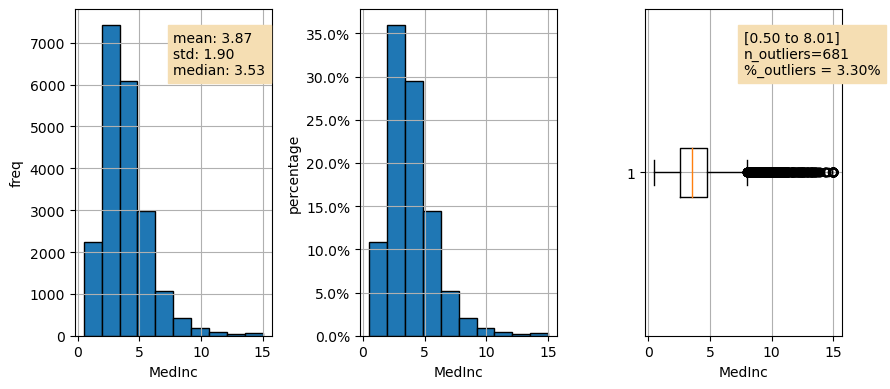

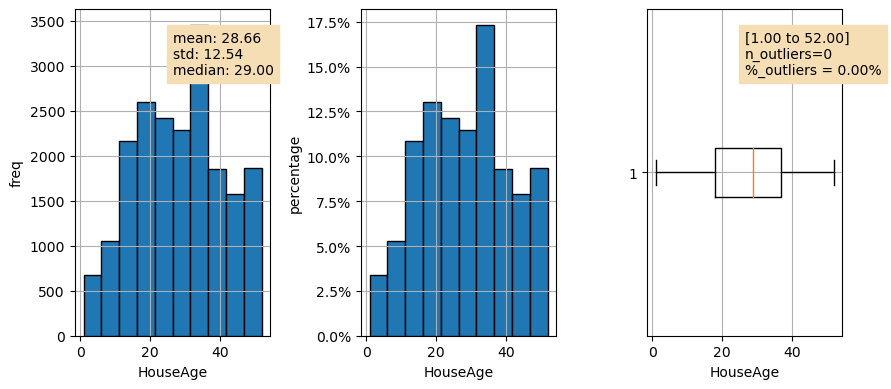

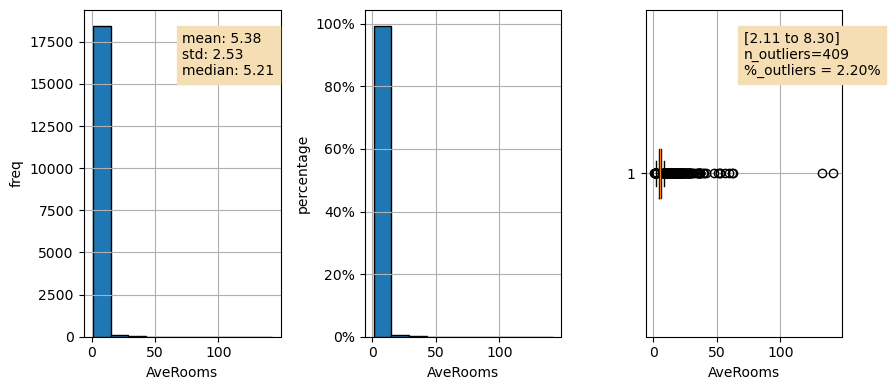

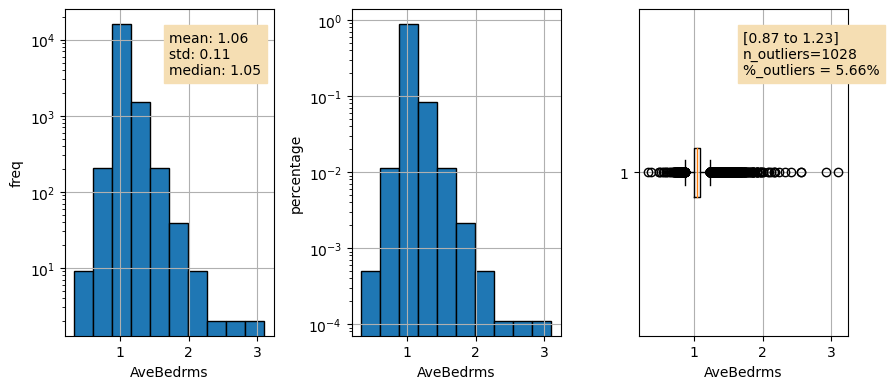

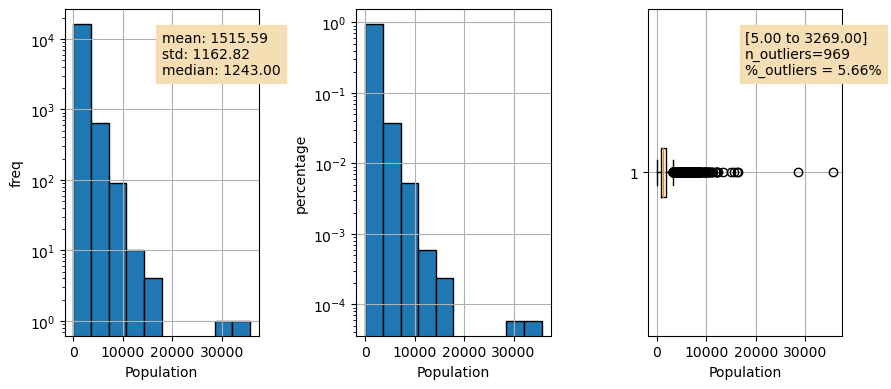

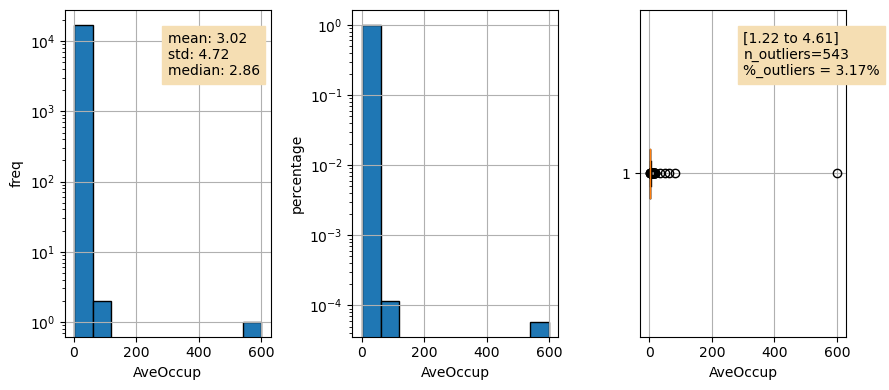

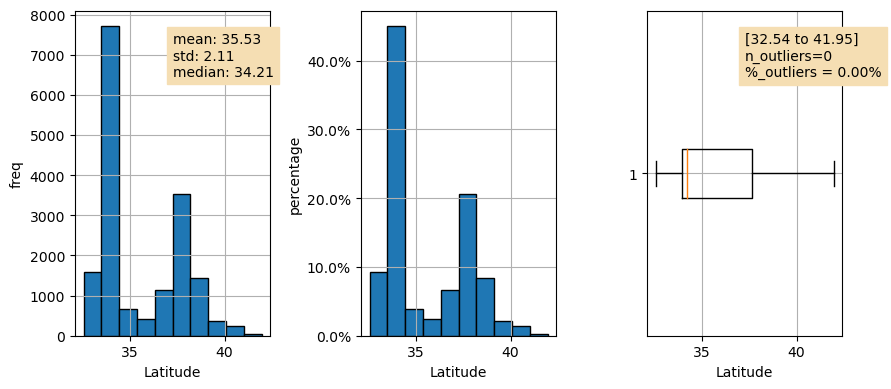

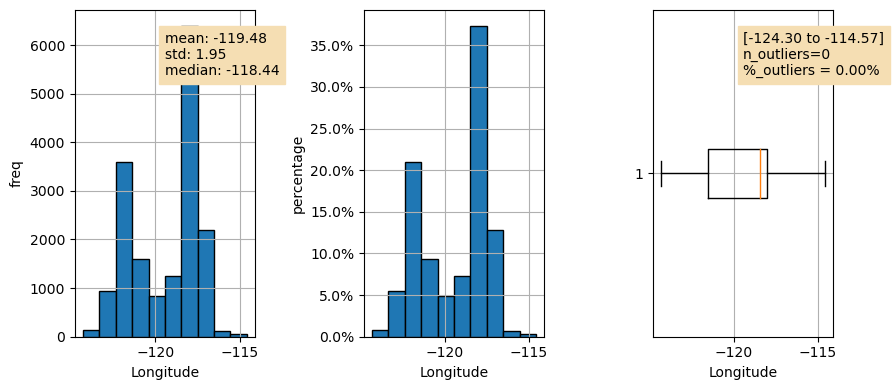

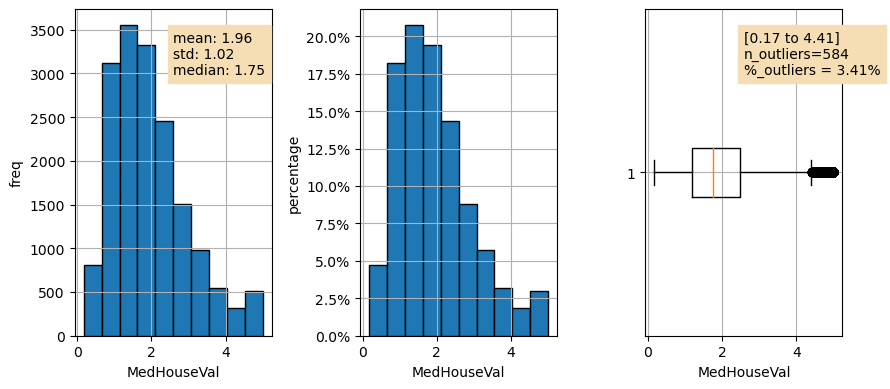

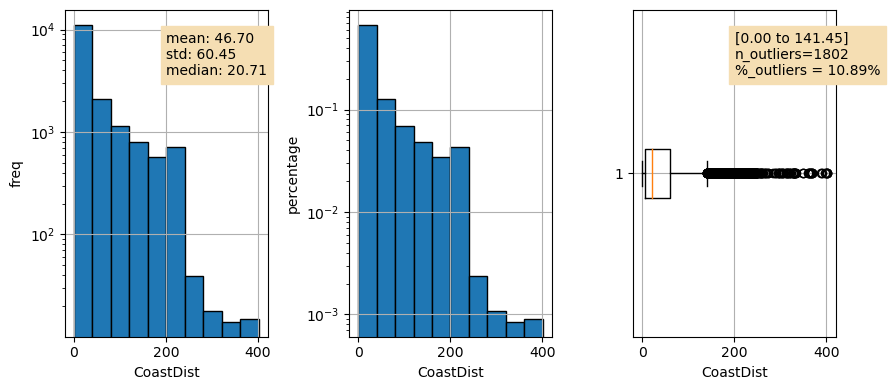

In [19]:
cols_to_analyse = df.columns
cols_to_remove_outliers = ['MedHouseVal','MedInc','AveRooms','AveBedrms']
cols_to_plot_log = ['AveBedrms','Population','AveOccup','CoastDist']


for col in cols_to_analyse:
    fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)
    ax = axes[0]
    ax.set_xlabel(col)
    ax.hist(df[col],edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.annotate(text= '\n'.join((
                       f'mean: {np.mean(df[col]):.2f}',
                       f'std: {np.std(df[col]):.2f}',
                       f'median: {np.median(df[col]):.2f}',
                       )),
                xy=(0.5,0.8),
                xycoords='axes fraction',
                backgroundcolor='wheat'
                )
    ax.grid(True)
    if(col in cols_to_plot_log):
        ax.set_yscale('log')
    
    ax = axes[1]
    ax.set_xlabel(col)
    ax.hist(df[col], weights=np.ones(len(df)) / len(df),edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel('percentage')
    ax.grid(True)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    if(col in cols_to_plot_log):
        ax.set_yscale('log')
    
    ax = axes[2]
    box = ax.boxplot(df[col],vert=False)
    lw = box['whiskers'][0].get_xdata()[1] # High whisker
    hw = box['whiskers'][1].get_xdata()[1] # Low whisker
    n_out = len(df[(df[col] < lw) | (df[col] > hw) ])
    ax.annotate(text= '\n'.join((
                       f'[{lw:.2f} to {hw:.2f}]',
                       f'n_outliers={n_out}',
                       f'%_outliers = {(n_out/len(df[col]))*100:.2f}%'
                       )),
                xy=(0.5,0.8),
                xycoords='axes fraction',
                backgroundcolor='wheat')
    ax.set_xlabel(col)
    ax.grid(True)

    # Remove outliers based on conclutions
    if(col in cols_to_remove_outliers):
        df = df[(df[col] > lw) & (df[col] < hw)]
    
    if(col == 'HouseAge'):
        df = df[(df[col]) < 50]
    
    if(col == 'AveOccup'):
        df = df[(df[col]) < 200]

    if(col == 'Population'):
        df = df[(df[col]) < 20000]

In [20]:
n_points_wo_outliers = len(df)

print(f'Luego de quitar outliers se ha retenido el {100*n_points_wo_outliers/n_points_raw:.2f}% de los datos')

Luego de quitar outliers se ha retenido el 80.14% de los datos


(16540, 10)

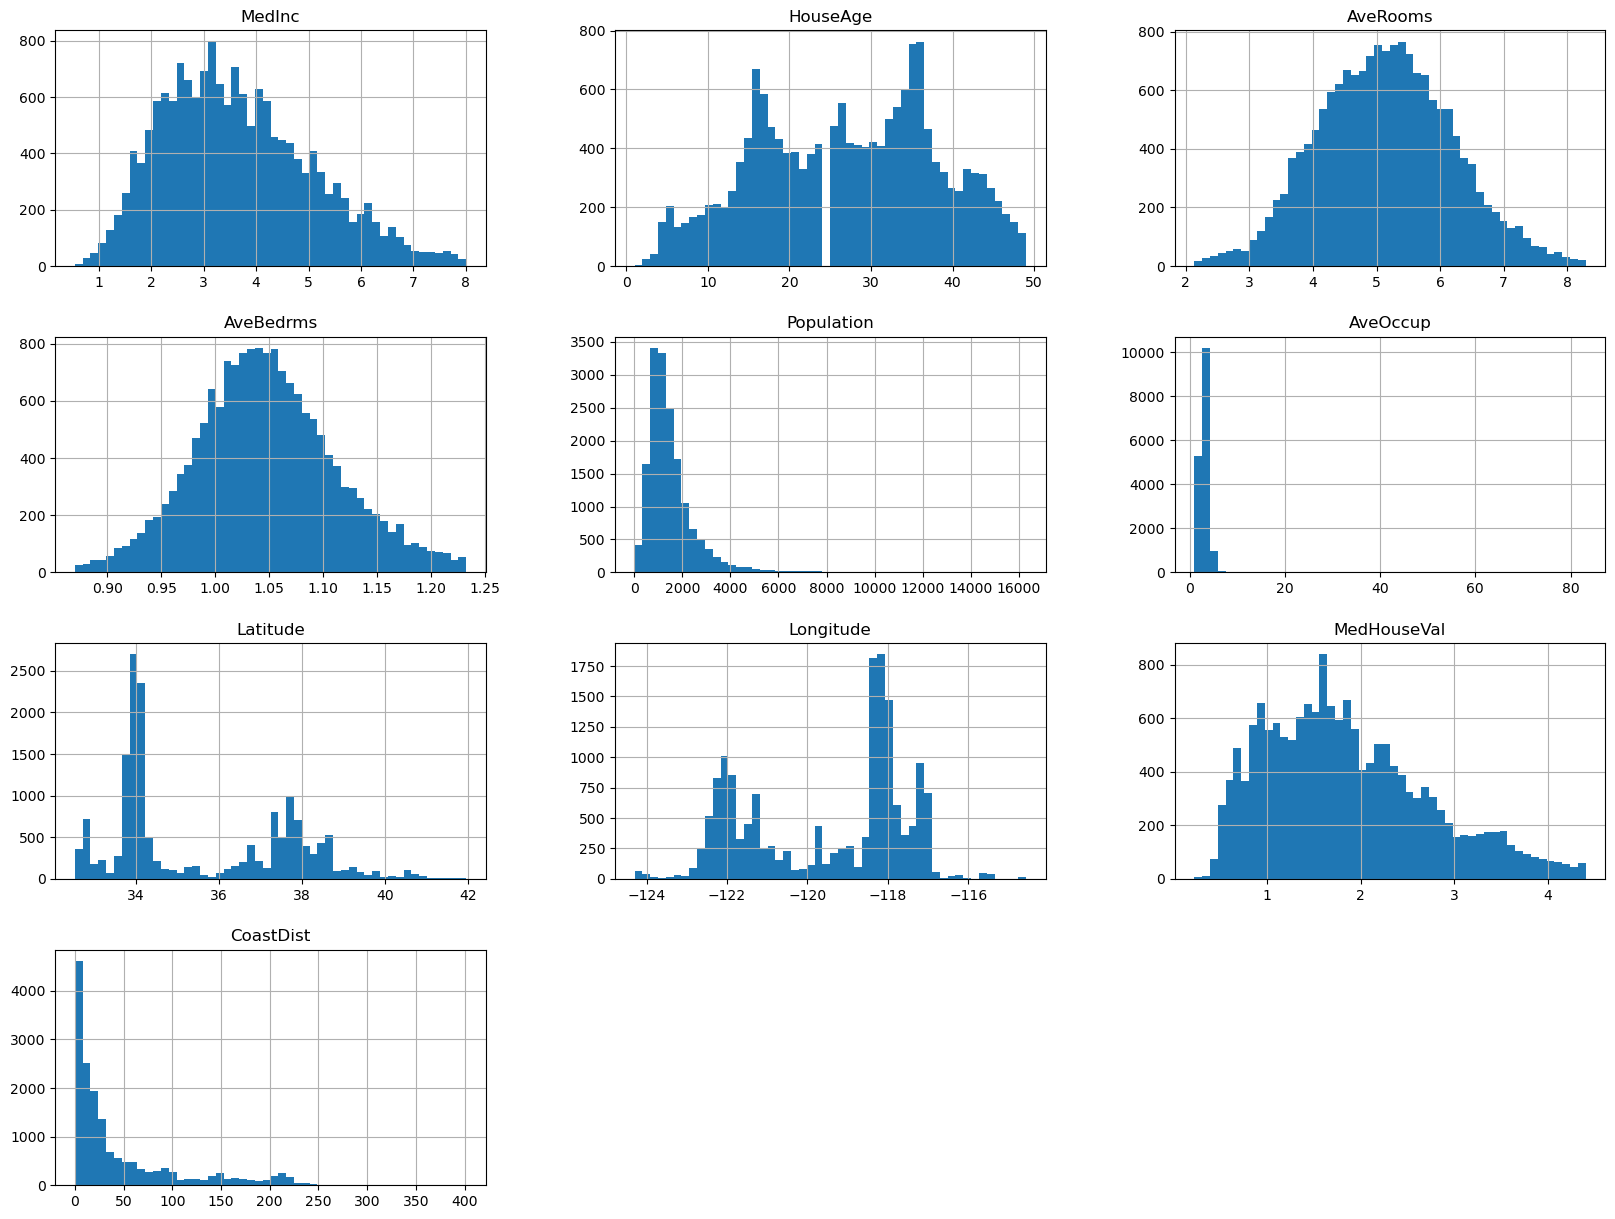

In [21]:
df.hist(bins=50,figsize=(20,15))
df.shape

## Correlación de Pearson

- Se utiliza la matriz de correlación para mostrar que:

- Existe una fuerte relación lineal directa entre la mediana del valor de las propiedades del condado con la mediana del ingreso del condado.
- Existe una correlación lineal directa más débil que la anterior entre la mediana del valor de las propiedades del condado con el promedio de cuartos de cada propiedad en el condado
- Existe una correlación lineal inversa importante entre la mediana del valor de las propiedades y su distancia a la costa

<Axes: >

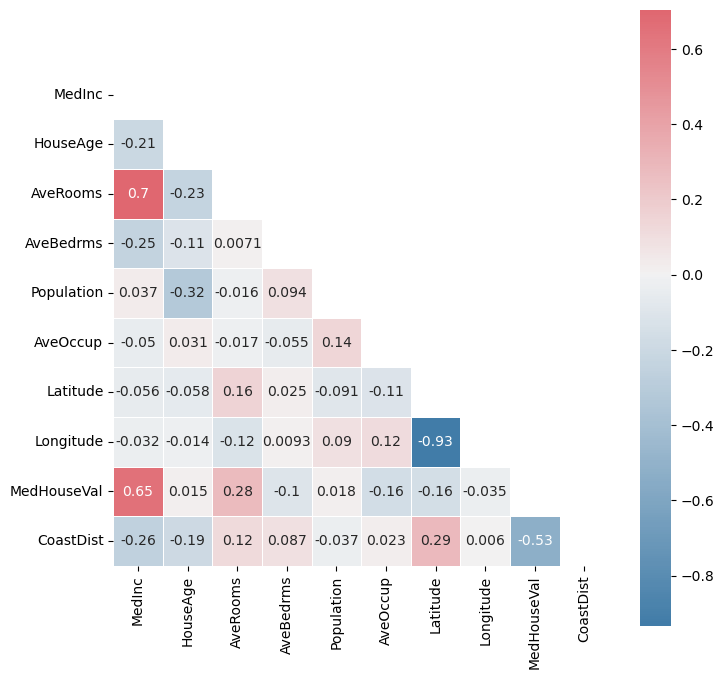

In [22]:
# Pearson Correlation
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

## Scaling

Scaling vs Normalization

- Escalar es hacer que el rango de datos se ajuste en una escala específica
- La normalización es una transformación que cambia las observaciones para que se describan con una distribución normal
- Sklearn provee diferentes scalers:
    - StandardScaler: Quita la media y escala los datos a una unidad de varianza
    - Robust: Similar al Standard pero escala al rango intercuartil
    - Normalizer: Escala cada dato para tener una norma unitaria (L2-Normalization)
    - MinMaxScaler: Reduce el rango de datos linealmente, sin alterar la distribución
    - PowerTransform: Ajusta a una gausseana
- Se muestra un ejemplo de cómo actúa cada scaler para la variable CoastDist del dataset
- Para algoritmos de clustering, es conveniente no alterar la relación entre las observaciones de una variable, se utilizará el MinMaxScaler

Text(0.5, 0, 'Normalizer')

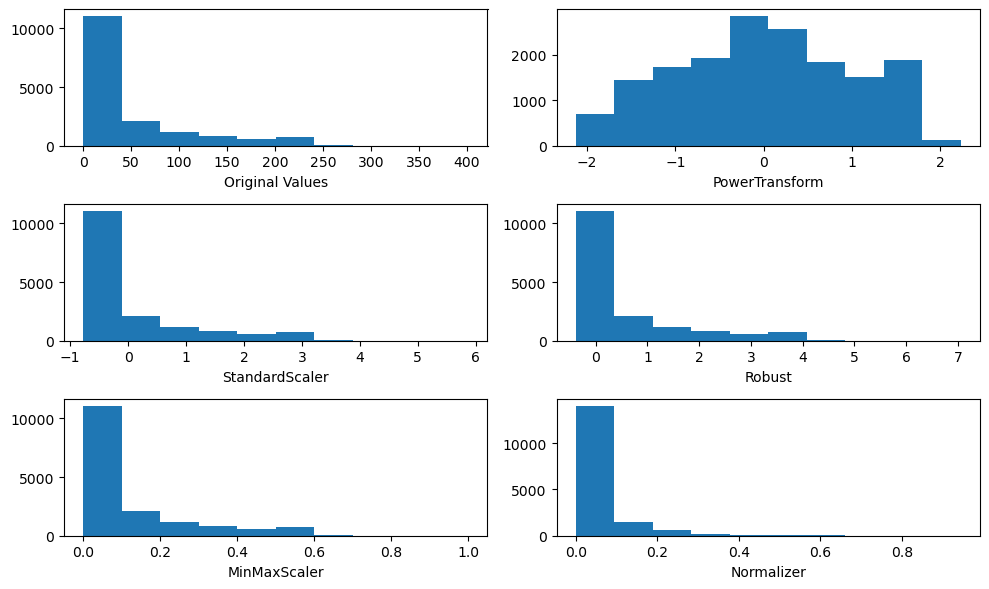

In [23]:
og = df['CoastDist']

CoastDist_std = StandardScaler().fit_transform(df)
CoastDist_norm = Normalizer().fit_transform(df)
CoastDist_minmax = MinMaxScaler().fit_transform(df)
CoastDist_gauss = PowerTransformer(method='yeo-johnson').fit_transform(df)
CoastDist_robust = RobustScaler().fit_transform(df)


fig, axes = plt.subplots(3,2,figsize=(10,6),tight_layout=True)
ax = axes[0,0]
ax.hist(df['CoastDist'])
ax.set_xlabel('Original Values')
ax = axes[0,1]
ax.hist(CoastDist_gauss[:,-1])
ax.set_xlabel('PowerTransform')
ax = axes[1,0]
ax.hist(CoastDist_std[:,-1])
ax.set_xlabel('StandardScaler')
ax = axes[1,1]
ax.hist(CoastDist_robust[:,-1])
ax.set_xlabel('Robust')
ax = axes[2,0]
ax.hist(CoastDist_minmax[:,-1])
ax.set_xlabel('MinMaxScaler')
ax = axes[2,1]
ax.hist(CoastDist_norm[:,-1])
ax.set_xlabel('Normalizer')


## Kmeans

- Se generan modelos variando la cantidad de clusters entre 2 y 15 y se calcula la inercia y la silueta
- Se busca el códo en la inercia y un valor elevado de silueta para seleccionar la cantidad de clusters
- Se encuentra que el valor óptimo de clusters es 6 y se genera la categorización del dataset
- Se muestran los clusters en un plot geográfico
- Se muestra además los valores medios de cada parámetro en cada clusters y sus desviaciones estándar.
- Se resume la información del valor medio y desviación estándar en una serie de Boxplot para cada columna, se mencionan algunas conclusiones a continuación.

Sobre el cluster dos:
    - Existe una diferencia estadísticamente significativa En el la medianda de las casas del cluster 2 respecto de los demás, siendo el cluster dos el de valores menores, mientras que los clusters 0, 3 y 4 tienen valores medios y los clusters 1 y 5 tienen los vlores más altos
    - Respecto a la antiguedad de las propiedades, el cluster 2 tiene un valor medio relativamente pequeño pero gran varianza, lo que indica que hay propiedades muy nuevas o muy viejas
    - El cluster 2 muestra una diferencia significativa en el valor medio de la distancia al mar, siendo mucho mayor al resto de los clusters
    - El cluster dos tiene el valor de ingresos medios del condado más bajo

Todo esto hace pensar que el cluster dos son urbanizaciones alejadas de la costa en condados emergentes. La gran variabilidad en edad de las propiedades hace pensar que la urbanización fue un proceso lento, donde el precio de la propiedad es menor y esto es atractivo para personas que cuentan con menores ingresos.

Sobre el cluster 1 y 5: 
    - La localización geográfica es alrededor de la bahía de San Francisco para el 5 y alrededor de Los Ángeles para el 1
    - Es notable que el cluster 5, junto con el 1, tiene un valor medio de cuartos superior a los demás clusters y comparten los valores medios de valor más alto de propiedad, coincidente también con los ingresos medios más altos respecto a los demás clusters
    - Con respecto a la distancia a la costa, ambos clusters muestran un bajo valor medio, coincidente con el hecho de que ambas ciudades colindan con el pacífico.

Esto indica que estos clusters agrupan propiedades en las dos urbes más grandes de California y es coincidente con el hecho de que el valor de la propiedad en las grandes ciudades es, generalmente, mayor respecto a otros sectores.

In [24]:
%%time


features = list(df.columns)
X = MinMaxScaler().fit_transform(df[features])

inertias = []
silhouettes = []
ks = np.arange(2,15)
for k in ks:
    model = KMeans(n_clusters=k,n_init='auto',random_state=42)
    model = model.fit(X)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X, model.labels_))

CPU times: total: 1min 57s
Wall time: 31.6 s


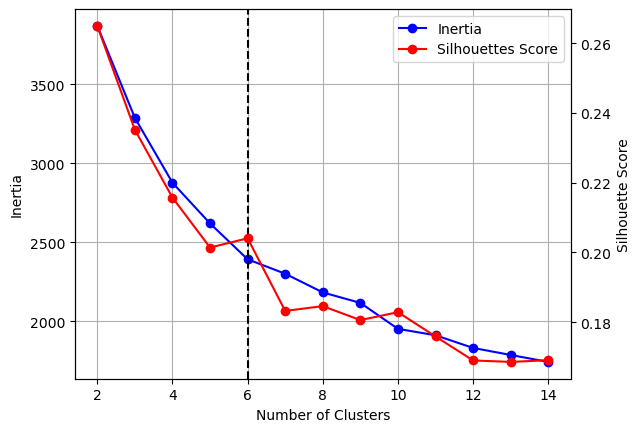

In [25]:
fig,ax = plt.subplots(1,1)
ax.set_ylabel('Inertia')
ax.set_xlabel('Number of Clusters')
i_line = ax.plot(ks,inertias,marker='o',color='blue',label='Inertia')

ax2 = ax.twinx()
ax2.set_ylabel('Silhouette Score')
sil_line = ax2.plot(ks,silhouettes,marker='o',color='red',label='Silhouettes Score')

#ax.legend(loc='upper right')
lines = i_line+sil_line
labels = [line.get_label() for line in lines]
ax.legend(lines,labels)
ax.grid()
ax.axvline(6,linestyle='--',color='k')

In [26]:
k = 6
model = KMeans(n_clusters=k,n_init='auto')
model = model.fit(X)
centers = model.cluster_centers_

In [27]:
centers = pd.DataFrame(data=centers,columns=list(features))
centers


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,CoastDist
0,0.562157,0.535410,0.574787,0.449843,0.090804,0.022453,0.548565,0.232045,0.557068,0.040298
1,0.508094,0.711153,0.511109,0.424552,0.071232,0.022992,0.146737,0.629375,0.540832,0.048603
2,0.286796,0.521209,0.476955,0.520947,0.081326,0.023483,0.580258,0.321523,0.198829,0.265084
3,0.263649,0.730613,0.334609,0.496694,0.090600,0.030567,0.148540,0.642197,0.289163,0.080881
4,0.698600,0.340387,0.707809,0.448256,0.117290,0.025077,0.138098,0.648851,0.577254,0.076699
5,0.345780,0.331856,0.421822,0.572251,0.125081,0.024222,0.134988,0.672950,0.323832,0.115373


In [28]:
dfKmeans = df.copy()
dfKmeans['Cluster'] = model.predict(X)
dfKmeans['Cluster'] = dfKmeans['Cluster'].astype("category")
dfKmeans

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,CoastDist,Cluster
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267,3.75,2
20,1.3578,40.0,4.524096,1.108434,409.0,2.463855,37.85,-122.27,1.475,2.70,2
21,1.7135,42.0,4.478142,1.002732,929.0,2.538251,37.85,-122.27,1.598,2.70,2
25,2.4038,41.0,4.495798,1.033613,317.0,2.663866,37.85,-122.28,1.075,1.66,2
26,2.4597,49.0,4.728033,1.020921,607.0,2.539749,37.85,-122.28,0.938,1.66,2
...,...,...,...,...,...,...,...,...,...,...,...
20634,3.7125,28.0,6.779070,1.148256,1041.0,3.026163,39.27,-121.56,1.168,140.48,2
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,183.71,2
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,171.99,2
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,168.03,2


<Axes: xlabel='Longitude', ylabel='Latitude'>

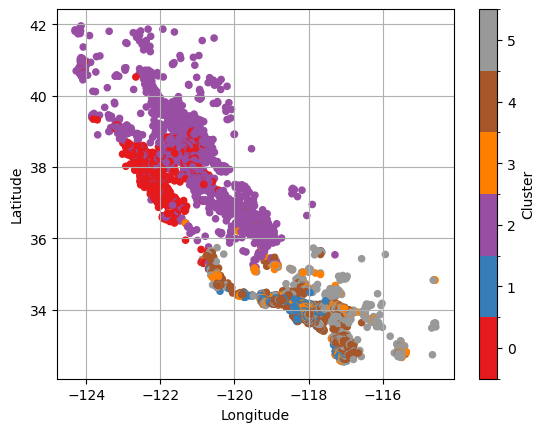

In [29]:
dfKmeans.plot(kind='scatter',x='Longitude',y='Latitude',alpha=1.0,
        c='Cluster',cmap='Set1',grid=True)

In [30]:
dfKmeans.groupby(by='Cluster').mean()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,CoastDist
Cluster,,,,,,,,,,
0,4.736550,26.699670,5.670987,1.032997,1485.102970,2.816217,37.701997,-122.042198,2.552431,16.181046
1,4.328952,35.152166,5.277508,1.023826,1165.898429,2.863089,33.920751,-118.175286,2.481357,19.554711
2,2.679060,26.016508,5.068964,1.058795,1330.467630,2.900824,38.000921,-121.172141,1.055814,106.430516
3,2.502717,36.060135,4.190937,1.050055,1483.965203,3.483123,33.938378,-118.052027,1.431579,32.526858
4,5.754938,17.348153,6.488282,1.032460,1916.375078,3.031162,33.839512,-117.987126,2.637898,30.764771
5,3.119950,16.925010,4.729900,1.077397,2042.753141,2.961585,33.810195,-117.752051,1.577865,46.336936


In [31]:
dfKmeans.groupby(by='Cluster').std()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,CoastDist
Cluster,,,,,,,,,,
0,1.184022,11.221217,0.990120,0.060724,1084.282075,1.063768,0.541236,0.418694,0.720060,24.340058
1,0.856607,5.920634,0.727114,0.057690,594.948035,0.894138,0.391211,0.512087,0.735017,17.542455
2,0.853644,11.038292,0.808358,0.067540,960.133758,0.817689,1.270964,1.160449,0.391800,78.668932
3,0.699328,6.073764,0.763113,0.063899,825.328974,0.991017,0.542212,0.666806,0.483825,40.174250
4,0.931892,7.303501,0.753211,0.058577,1627.777786,0.494021,0.655830,0.837039,0.696377,37.168491
5,0.863943,6.288841,0.892269,0.063358,1442.448412,2.217975,0.669254,0.905059,0.567465,54.407275


AveBedrms         Axes(0.125,0.653529;0.168478x0.226471)
AveOccup       Axes(0.327174,0.653529;0.168478x0.226471)
AveRooms       Axes(0.529348,0.653529;0.168478x0.226471)
CoastDist      Axes(0.731522,0.653529;0.168478x0.226471)
HouseAge          Axes(0.125,0.381765;0.168478x0.226471)
Latitude       Axes(0.327174,0.381765;0.168478x0.226471)
Longitude      Axes(0.529348,0.381765;0.168478x0.226471)
MedHouseVal    Axes(0.731522,0.381765;0.168478x0.226471)
MedInc                Axes(0.125,0.11;0.168478x0.226471)
Population         Axes(0.327174,0.11;0.168478x0.226471)
dtype: object

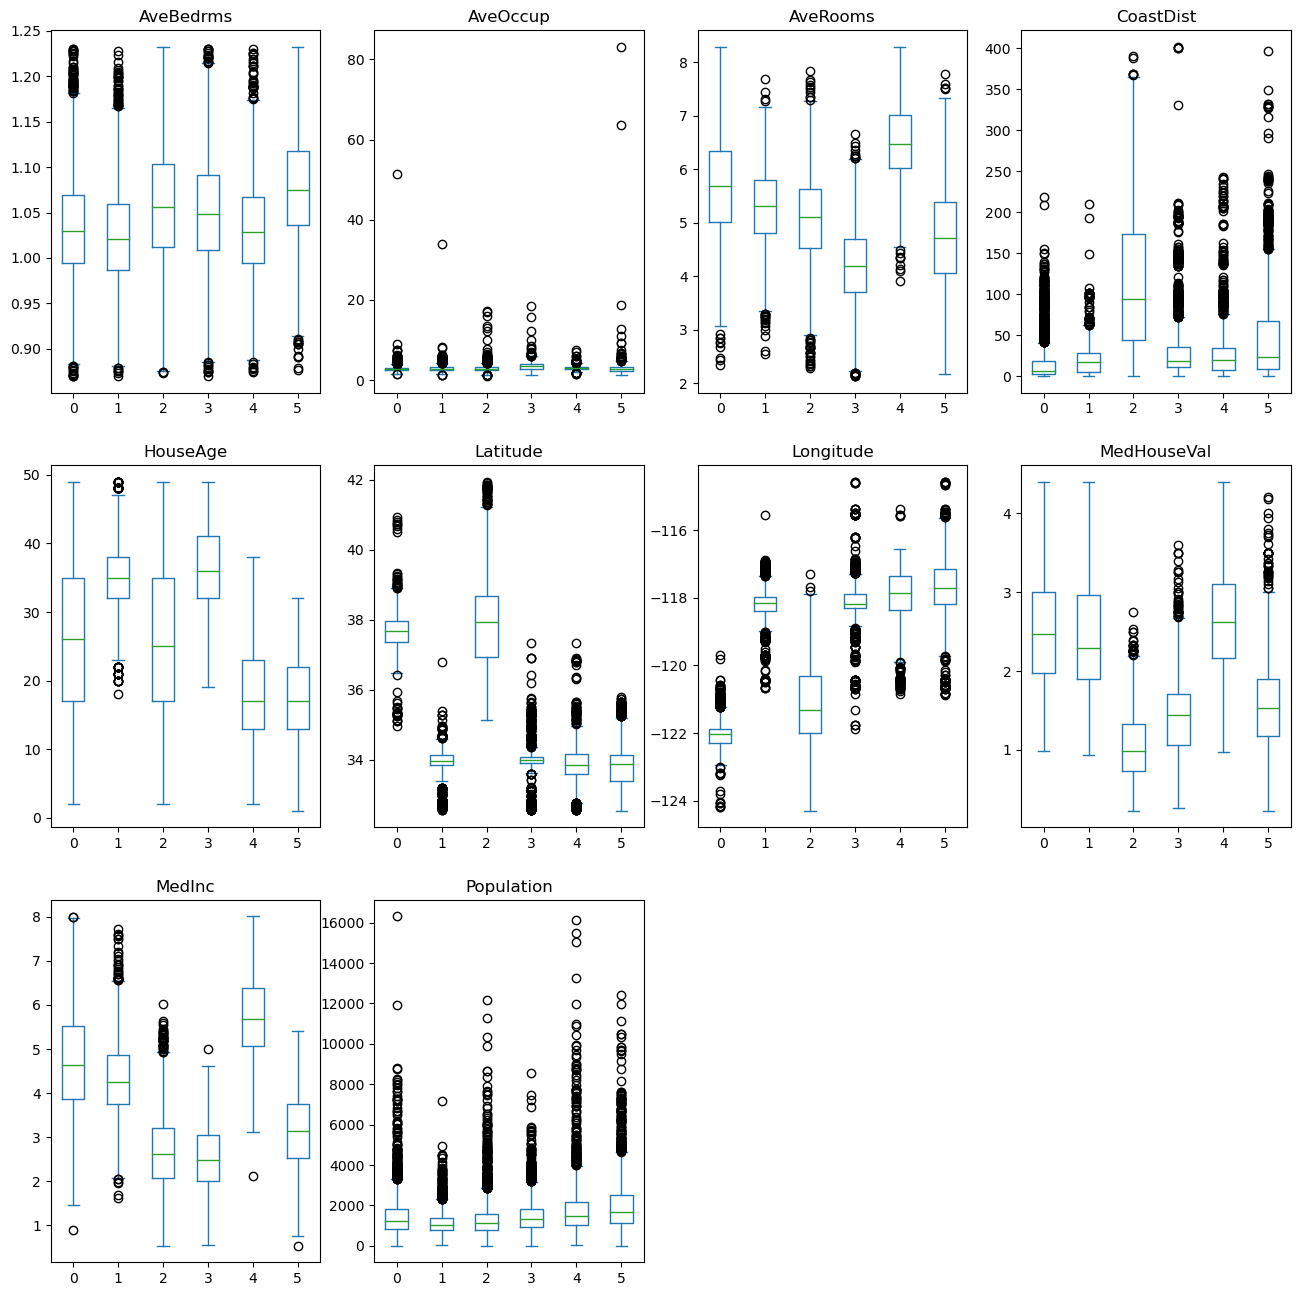

In [32]:
dfKmeans.plot.box(by='Cluster',figsize=(16,16),layout=(3,4))

## DBSCAN

- Para realizar el análisis con DBSCAN previamente se escalan los datos con un MinMaxScaler
- Debido al alto costo computacional de DBSCAN, se realiza una exploración previa calculando la distancia euclidea de cada punto con los demás N-1 puntos del dataset escalado. Al tener 10 features esta distancia es en $R^{10}$. Luego se obtiene la distancia media a los M puntos vecinos. Se puede variar la cantidad de vecinos M para ver cuál es la distancia media al considerar más o menos vecinos y se generan modelos de DBSCAN con $\epsilon$ igual a la distancia media y samples igual al número de vecinos considerados para obtener esa distancia media.
- Se muestra el valor de silueta y el porcentaje de ruido que genera cada uno de esos modelos
- Se selecciona un modelo con $\epsilon$ = 0.173382 y samples = 30, que genera 4 clusters y tienen un 33% de ruido, aproximadamente
- Se muestra los cluster en la distribución geográfica y el boxplot para sacar conclusiones

Observando los boxplots y la ubicación geográfica se puede llegar a conclusiones interesantes de los datasets 0 y 3:
    - En el plot geográfico se puede apreciar que estos puntos pertenecen a las grandes urbes de Los Ángeles y San Francisco, lo que es consistente con su alto MedHouseVal, alto MedInc y bajo CoastDist
    - En las demás variables no se presentan diferencias estadísticamente significativas, por lo que se puede decir que DBSCAN ha encontrado una mayor uniformidad entre los clusters que kmeans, siendo más sensible a estas variables para generar la clusterización.

In [33]:
features = list(df.columns)
X = MinMaxScaler().fit_transform(df[features])

In [34]:
len(X)

16540

In [35]:
""" 
%%time
# Se guarda el array de distancias en disco

dists = np.zeros((len(X),len(X)))
for point_ptr in range(len(X)):
    point = X[point_ptr]
    for ptr in range(len(X)):
        dists[point_ptr,ptr] = math.dist(point,X[ptr])

dists_sorted = np.sort(dists,axis=1)
dists_sorted

np.save('./datasets/distances_sorted.npy',dists_sorted)

#CPU times: total: 14min 32s
#Wall time: 14min 32s
"""

" \n%%time\n# Se guarda el array de distancias en disco\n\ndists = np.zeros((len(X),len(X)))\nfor point_ptr in range(len(X)):\n    point = X[point_ptr]\n    for ptr in range(len(X)):\n        dists[point_ptr,ptr] = math.dist(point,X[ptr])\n\ndists_sorted = np.sort(dists,axis=1)\ndists_sorted\n\nnp.save('./datasets/distances_sorted.npy',dists_sorted)\n\n#CPU times: total: 14min 32s\n#Wall time: 14min 32s\n"

In [36]:
dists_sorted = np.load('./datasets/distances_sorted.npy')

In [37]:
ns = np.arange(1,len(X)-1,100)
mean_dist_by_n = []

for n_neighbors in ns:

    dist_to_n_neighbors = dists_sorted[:,1:n_neighbors+1]
    mean_dist = np.mean(dist_to_n_neighbors,axis=1)
    mean_dist = np.mean(mean_dist,axis=0)
    mean_dist_by_n.append(mean_dist)

Text(0.5, 0, 'N Neighbors')

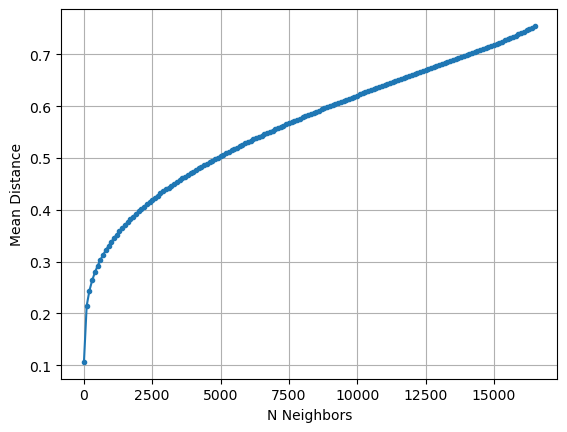

In [38]:
fig,ax = plt.subplots(1,1)
ax.plot(ns,mean_dist_by_n,marker='.')
ax.grid()
ax.set_ylabel('Mean Distance')
ax.set_xlabel('N Neighbors')

In [39]:
ns = np.arange(1,1000,10)
mean_dist_by_n = []

for n_neighbors in ns:

    dist_to_n_neighbors = dists_sorted[:,1:n_neighbors+1]
    mean_dist = np.mean(dist_to_n_neighbors,axis=1)
    mean_dist = np.mean(mean_dist,axis=0)
    mean_dist_by_n.append(mean_dist)

Text(0.5, 0, 'N Neighbors')

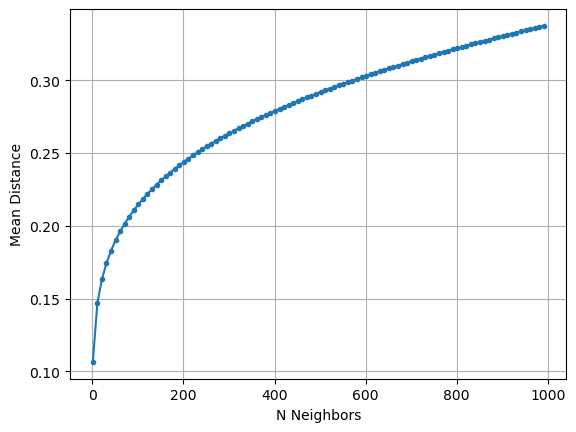

In [40]:
fig,ax = plt.subplots(1,1)
ax.plot(ns,mean_dist_by_n,marker='.')
ax.grid()
ax.set_ylabel('Mean Distance')
ax.set_xlabel('N Neighbors')

In [41]:
ns = [10,20,30,40,50,100,200,300,400,600,800,1000]
mean_dist_by_n = []

for n_neighbors in ns:

    dist_to_n_neighbors = dists_sorted[:,1:n_neighbors+1]
    mean_dist = np.mean(dist_to_n_neighbors,axis=1)
    mean_dist = np.mean(mean_dist,axis=0)
    mean_dist_by_n.append(mean_dist)



test_cases = list(zip(ns, mean_dist_by_n))

print(len(test_cases))

silhouette_scores = []
noise = []
numclusters = []

for test_case in test_cases:
    samples = test_case[0]
    eps = test_case[1]
    
    test = DBSCAN(eps=eps, min_samples=samples)
    test.fit(X)
    try:
        silhouette_scores.append(silhouette_score(X, test.labels_))
    except:
        silhouette_scores.append(-1)
    labels,n = np.unique(test.labels_,return_counts=True)

    if(-1 in labels): # Noisy
        noise.append(n[0])
    else:
        noise.append(0)
    numclusters.append(len(labels[labels>=0]))

dbs_test_models = pd.DataFrame(data=test_cases,columns=['samples','eps'])
dbs_test_models['noisy'] = [n>0 for n in noise]
dbs_test_models['noise'] = noise
dbs_test_models['noise_%'] = 100*np.array(noise)/len(X)
dbs_test_models['sil_scores'] = silhouette_scores
dbs_test_models['numclusters'] = numclusters

12


In [42]:
dfPlot = dbs_test_models[dbs_test_models['numclusters'] > 1]
dfPlot

,samples,eps,noisy,noise,noise_%,sil_scores,numclusters
0,10,0.144649,True,6086,36.795647,-0.172378,11
1,20,0.161925,True,5853,35.386941,0.021382,5
2,30,0.173382,True,5586,33.772672,0.084512,4
3,40,0.182166,True,5431,32.835550,0.088040,4
4,50,0.189384,True,5318,32.152358,0.087600,4
5,100,0.214318,True,5134,31.039903,0.111249,3
6,200,0.243718,True,4795,28.990326,0.107644,3
7,300,0.263482,True,4882,29.516324,0.174885,2
8,400,0.278902,True,4714,28.500605,0.178824,2
9,600,0.302973,True,4774,28.863362,0.172594,2


In [43]:
eps = 0.189384
samples = 50

model = DBSCAN(eps=eps, min_samples=samples)
model.fit(X)
labels = model.labels_
l,c = np.unique(labels,return_counts=True)
print('Clusters',l)
print('Points per cluster',c)
print(f'Noise: {100*c[0]/len(X):.2f}%')
print(f'Silhoutte Score {silhouette_score(X, labels):.4f}')


Clusters [-1  0  1  2  3]
Points per cluster [5318 3283  135  566 7238]
Noise: 32.15%
Silhoutte Score 0.0876


In [44]:
dfDBSCAN = df.copy()
dfDBSCAN['Cluster'] = model.labels_
dfDBSCAN['Cluster'] = dfDBSCAN['Cluster'].astype("category")
dfDBSCAN

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,CoastDist,Cluster
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267,3.75,0
20,1.3578,40.0,4.524096,1.108434,409.0,2.463855,37.85,-122.27,1.475,2.70,0
21,1.7135,42.0,4.478142,1.002732,929.0,2.538251,37.85,-122.27,1.598,2.70,0
25,2.4038,41.0,4.495798,1.033613,317.0,2.663866,37.85,-122.28,1.075,1.66,0
26,2.4597,49.0,4.728033,1.020921,607.0,2.539749,37.85,-122.28,0.938,1.66,0
...,...,...,...,...,...,...,...,...,...,...,...
20634,3.7125,28.0,6.779070,1.148256,1041.0,3.026163,39.27,-121.56,1.168,140.48,-1
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,183.71,-1
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,171.99,1
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,168.03,-1


<Axes: title={'center': 'DBSCAN - $\\epsilon$=0.189384, samples = 50'}, xlabel='Longitude', ylabel='Latitude'>

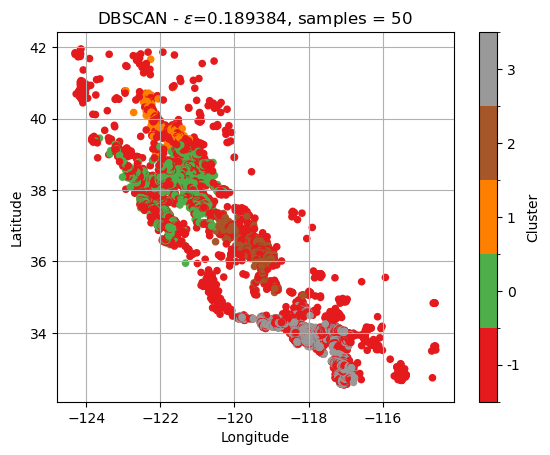

In [45]:
dfDBSCAN.plot(kind='scatter',x='Longitude',y='Latitude',alpha=1.0,
        c='Cluster',cmap='Set1',grid=True,title=f'DBSCAN - $\epsilon$={eps}, samples = {samples}')

AveBedrms         Axes(0.125,0.653529;0.168478x0.226471)
AveOccup       Axes(0.327174,0.653529;0.168478x0.226471)
AveRooms       Axes(0.529348,0.653529;0.168478x0.226471)
CoastDist      Axes(0.731522,0.653529;0.168478x0.226471)
HouseAge          Axes(0.125,0.381765;0.168478x0.226471)
Latitude       Axes(0.327174,0.381765;0.168478x0.226471)
Longitude      Axes(0.529348,0.381765;0.168478x0.226471)
MedHouseVal    Axes(0.731522,0.381765;0.168478x0.226471)
MedInc                Axes(0.125,0.11;0.168478x0.226471)
Population         Axes(0.327174,0.11;0.168478x0.226471)
dtype: object

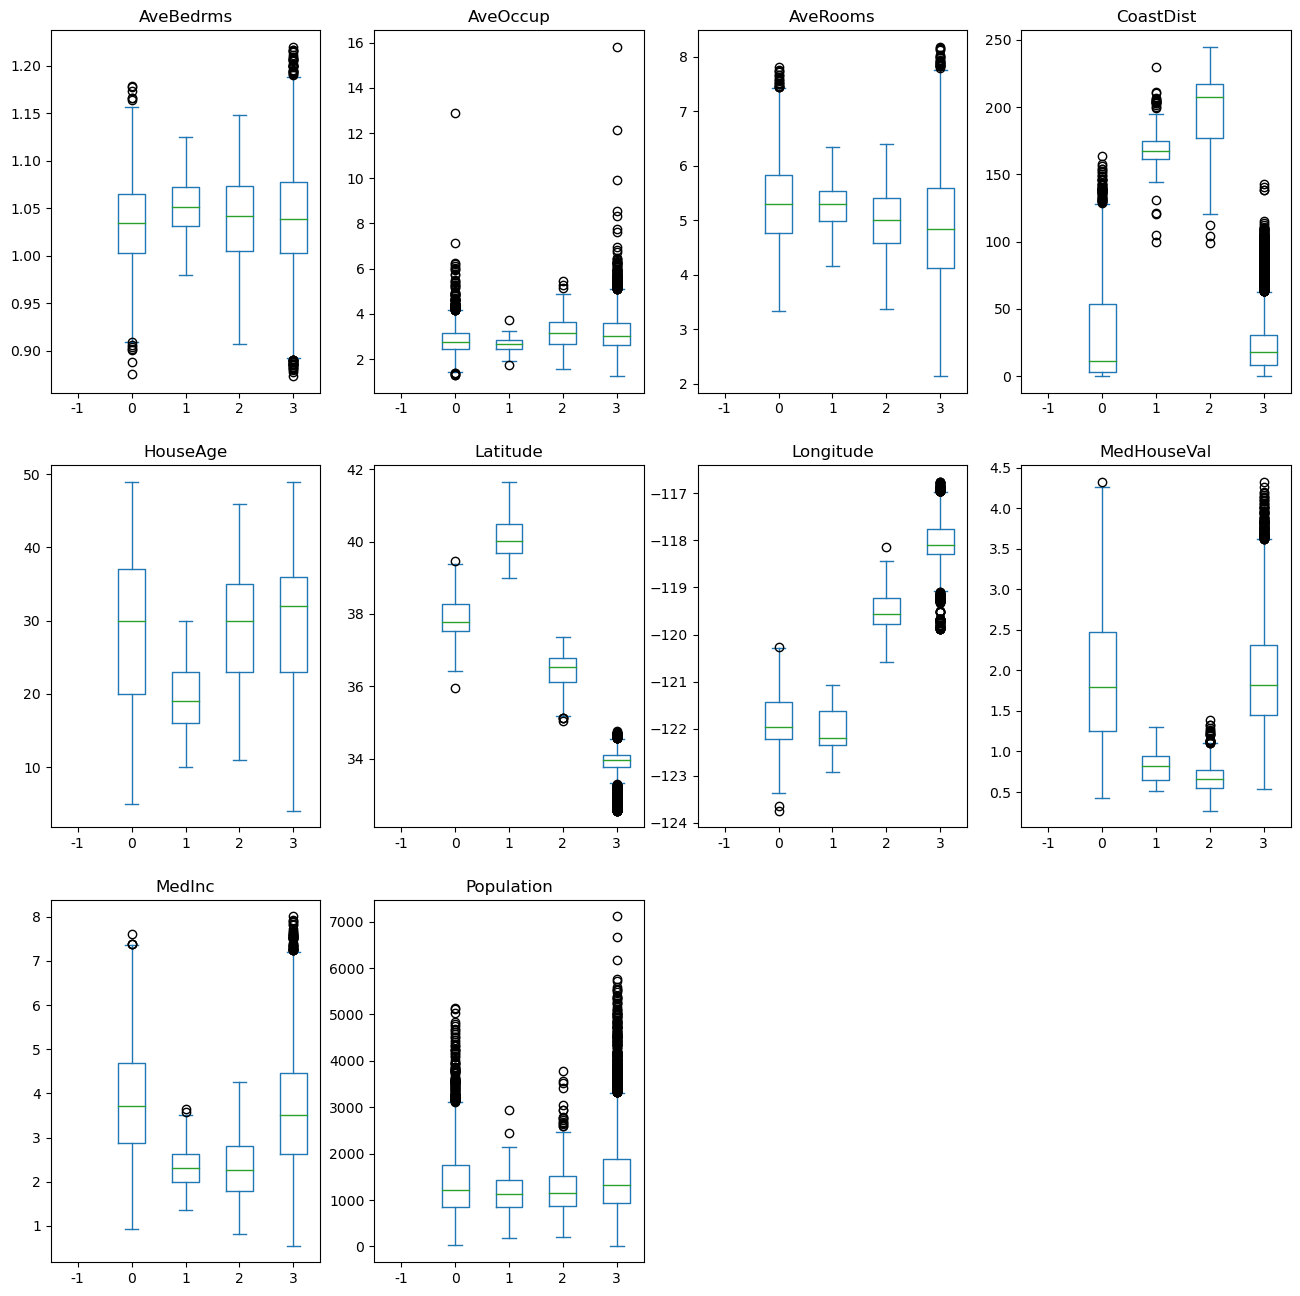

In [46]:
dfDBSCAN_noiseless = dfDBSCAN[dfDBSCAN.Cluster != -1]
dfDBSCAN_noiseless.plot.box(by='Cluster',figsize=(16,16),layout=(3,4))